In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

from scipy.stats import mode 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_samples, silhouette_score

import math

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
data_dir = '../../../data/processed/viviendas_tlajo/'

In [3]:
# hex_cluster = gpd.read_file('../data/processed/hex_clusters.geojson')

In [4]:
# hex_cluster.groupby('cluster').agg(['mean','median','std','count']).to_csv('../data/processed/cluster_stats.csv')

In [5]:
# hex_cluster.groupby('cluster').agg('mean','median','std').to_csv('../data/processed/cluster_stats_mean.csv')

In [3]:
hex_socio = gpd.read_file(f'{data_dir}hex_sociodemographic.geojson')
hex_eco = gpd.read_file(f'{data_dir}hex_denue.geojson')
hex_infra = gpd.read_file(f'{data_dir}hex_infraestructura.geojson')
hex_env = gpd.read_file(f'{data_dir}hex_environmental.geojson')
# hex_con = gpd.read_file(f'{data_dir}hex_connectivity.geojson')
hex_us = gpd.read_file(f'{data_dir}hex_urban_structure.geojson')
hex_prox = gpd.read_file(f'{data_dir}hex_proximity.geojson')
hex_aoi = gpd.read_file(f'{data_dir}AOI_Viviendas_Tlajo_v2.geojson')

## Data treatment

In [4]:
# hex_gdf = hex_eco[['hex_id_9','geometry']].copy()
hex_gdf = hex_aoi.copy()
print(hex_gdf.shape)
hex_gdf.head(2)

(101, 2)


,hex_id_9,geometry
0,8949aa2c4b7ffff,"POLYGON ((-103.3415 20.49336, -103.34029 20.49..."
1,8949aa2c503ffff,"POLYGON ((-103.34941 20.50946, -103.34819 20.5..."


#### Filter

In [5]:
# hex_filter = gpd.read_file(f'{data_dir}hex_filter.geojson')
# hex_gdf = hex_gdf.loc[hex_gdf.hex_id_9.isin(list(hex_filter.hex_id_9.unique()))]
# print(hex_gdf.shape)
# hex_gdf.head(2)

#### Spatial filter

In [6]:
# gdf = gpd.read_file(f'{data_dir}PoligonoEstudio_DistritoQRO_GCS_v1.geojson')
# gdf['geometry'] = gdf.to_crs("EPSG:32614").buffer(1500)
# gdf = gdf.to_crs("EPSG:4326")
# hex_clip = gpd.clip(hex_gdf, gdf)
# hex_gdf = hex_gdf.loc[hex_gdf.hex_id_9.isin(list(hex_clip.hex_id_9.unique()))]
print(hex_gdf.shape)
hex_gdf.head(2)

(101, 2)


,hex_id_9,geometry
0,8949aa2c4b7ffff,"POLYGON ((-103.3415 20.49336, -103.34029 20.49..."
1,8949aa2c503ffff,"POLYGON ((-103.34941 20.50946, -103.34819 20.5..."


In [7]:
hex_socio = hex_socio.loc[hex_socio.hex_id_9.isin(list(hex_gdf.hex_id_9))].copy()
hex_eco = hex_eco.loc[hex_eco.hex_id_9.isin(list(hex_gdf.hex_id_9))].copy()
hex_infra = hex_infra.loc[hex_infra.hex_id.isin(list(hex_gdf.hex_id_9))].copy()
hex_env = hex_env.loc[hex_env.hex_id.isin(list(hex_gdf.hex_id_9))].copy()
# hex_con = gpd.read_file(f'{data_dir}hex_connectivity.geojson')
hex_us = hex_us.loc[hex_us.hex_id_9.isin(list(hex_gdf.hex_id_9))].copy()
hex_prox = hex_prox.loc[hex_prox.hex_id.isin(list(hex_gdf.hex_id_9))].copy()

### Sociodemographic

In [8]:
hex_socio.head(2)

,hex_id_9,CVEGEO,NOMGEO,city,type,nse_idx,hex_id,graproes,dens_pob_ha,auto_viv,pct_0_17,pct_18_59,pct_60_mas,wgt_imn,geometry
1,8949aa2eac7ffff,14097,Tlajomulco de Zúñiga,Guadalajara,urban,-0.141944,8949aa2eac7ffff,10.977333,49.886642,0.620759,0.370837,0.587962,0.041201,0.966714,"POLYGON ((-103.3676 20.51782, -103.36638 20.51..."
2,8949aa2eaa3ffff,14097,Tlajomulco de Zúñiga,Guadalajara,urban,0.175962,8949aa2eaa3ffff,10.320000,131.150694,0.481224,0.360334,0.597094,0.042571,0.961679,"POLYGON ((-103.37984 20.52226, -103.37863 20.5..."


In [9]:
hex_socio = hex_socio[['hex_id_9','nse_idx','graproes',
                       'dens_pob_ha',
                       'auto_viv','pct_0_17','pct_18_59',
                       'pct_60_mas','wgt_imn']]
socio_cols = ['nse_idx',
              'graproes','dens_pob_ha',
                       'auto_viv','pct_0_17','pct_18_59',
                       'pct_60_mas','wgt_imn']
hex_socio = hex_socio.fillna(0)
hex_socio_std = hex_socio.copy()
hex_socio_std[socio_cols] = StandardScaler().fit_transform(np.array(hex_socio[socio_cols]))
print(hex_socio_std.shape)
hex_socio_std.head(2)

(101, 9)


,hex_id_9,nse_idx,graproes,dens_pob_ha,auto_viv,pct_0_17,pct_18_59,pct_60_mas,wgt_imn
1,8949aa2eac7ffff,-2.291134,1.662958,-1.019740,2.676178,-0.183227,0.280352,0.107188,0.407487
2,8949aa2eaa3ffff,-1.558402,1.103190,0.297498,1.491844,-0.419429,0.433393,0.218548,0.354137


In [10]:
pca = PCA(n_components=3)

x = hex_socio_std.loc[:, socio_cols].values

principalComponents = pca.fit_transform(x)

In [11]:
print('Explained ratio:',pca.explained_variance_ratio_,'Explained variance:',pca.explained_variance_ratio_.sum())

Explained ratio: [0.49354561 0.29658504 0.12303022] Explained variance: 0.9131608658495179


In [12]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc_1', 'pc_2','pc_3'])

hex_socio_pca = hex_socio[['hex_id_9']]
hex_socio_pca.loc[:,['socio_pc_1','socio_pc_2','socio_pc_3']]= np.nan, np.nan, np.nan
hex_socio_pca.loc[:,'socio_pc_1'] = principalDf['pc_1'].copy()
hex_socio_pca.loc[:,'socio_pc_2'] = principalDf['pc_2'].copy()
hex_socio_pca.loc[:,'socio_pc_3'] = principalDf['pc_3'].copy()

### Economic

In [13]:
hex_eco.head(2)

,hex_id_9,denue_count,denue_jobs,denue_0_5,denue_6_10,denue_11_30,denue_31_50,denue_51_100,denue_101_250,denue_250_mas,denue_jobs_>_11,pct_jobs_>_11,geometry
5,8949aa2c4b7ffff,117.766667,440.133333,109.00,5.516667,3.05,0.2,0.00,0.0,0.0,69.00,0.156771,"POLYGON ((-103.3415 20.49336, -103.34029 20.49..."
6,8949aa2c503ffff,266.750000,1034.000000,250.25,9.000000,5.75,1.0,0.75,0.0,0.0,211.25,0.204304,"POLYGON ((-103.34941 20.50946, -103.34819 20.5..."


In [14]:
hex_eco = hex_eco[['hex_id_9','denue_count','denue_jobs','denue_jobs_>_11',
                   'pct_jobs_>_11',]]
eco_cols = ['denue_count','denue_jobs','denue_jobs_>_11',
                   'pct_jobs_>_11']
hex_eco = hex_eco.fillna(0)
hex_eco_std = hex_eco.copy()
hex_eco_std[eco_cols] = StandardScaler().fit_transform(np.array(hex_eco[eco_cols]))
print(hex_eco_std.shape)
hex_eco_std.head(2)

(101, 5)


,hex_id_9,denue_count,denue_jobs,denue_jobs_>_11,pct_jobs_>_11
5,8949aa2c4b7ffff,-2.200634,-2.035744,-1.732245,-2.371956
6,8949aa2c503ffff,-1.790824,-1.705239,-1.523977,-1.510179


In [15]:
pca = PCA(n_components=2)

x = hex_eco_std.loc[:, eco_cols].values

principalComponents = pca.fit_transform(x)

In [16]:
print('Explained ratio:',pca.explained_variance_ratio_,'Explained variance:',pca.explained_variance_ratio_.sum())

Explained ratio: [0.89160415 0.10047101] Explained variance: 0.9920751557480872


In [17]:
hex_eco_pca = hex_eco[['hex_id_9']]
hex_eco_pca.loc[:,['eco_pc_1','eco_pc_2',]] = np.nan, np.nan,
hex_eco_pca.loc[:,'eco_pc_1'] = principalComponents[:,0]
hex_eco_pca.loc[:,'eco_pc_2'] = principalComponents[:,1]

### Infraestructure

In [18]:
hex_infra.head(2)

,hex_id,CVEGEO,NOMGEO,city,type,pct_BANQUETA,pct_ALUMPUB,pct_RAMPAS,pct_ARBOLES,pct_CICLOVIA,geometry
1,8949aa2eac7ffff,14097,Tlajomulco de Zúñiga,Guadalajara,urban,0.363806,0.641017,0.333490,0.233378,0.0,"POLYGON ((670209.642 2269635.158, 670334.867 2..."
2,8949aa2eaa3ffff,14097,Tlajomulco de Zúñiga,Guadalajara,urban,0.902184,0.609658,0.692784,0.541320,0.0,"POLYGON ((668927.995 2270113.988, 669053.22 22..."


In [19]:
hex_infra = hex_infra.rename(columns={'hex_id':'hex_id_9'})

In [20]:
hex_infra = hex_infra[['hex_id_9','pct_BANQUETA','pct_ALUMPUB',
                      'pct_RAMPAS','pct_ARBOLES','pct_CICLOVIA']]
infra_cols = ['pct_BANQUETA','pct_ALUMPUB',
                      'pct_RAMPAS','pct_ARBOLES','pct_CICLOVIA']
hex_infra = hex_infra.fillna(0)
hex_infra_std = hex_infra.copy()
hex_infra_std[infra_cols] = StandardScaler().fit_transform(np.array(hex_infra[infra_cols]))
print(hex_infra_std.shape)
hex_infra_std.head(2)

(101, 6)


,hex_id_9,pct_BANQUETA,pct_ALUMPUB,pct_RAMPAS,pct_ARBOLES,pct_CICLOVIA
1,8949aa2eac7ffff,-2.485887,0.606282,-1.899470,-1.218561,-0.147271
2,8949aa2eaa3ffff,0.176585,0.416205,-0.400061,-0.079188,-0.147271


In [21]:
pca = PCA(n_components=3)

x = hex_infra_std.loc[:, infra_cols].values

principalComponents = pca.fit_transform(x)

In [22]:
print('Explained ratio:',pca.explained_variance_ratio_,'Explained variance:',pca.explained_variance_ratio_.sum())

Explained ratio: [0.47598892 0.20190428 0.16347105] Explained variance: 0.8413642483244035


In [23]:
hex_infra_pca = hex_infra[['hex_id_9']]
hex_infra_pca.loc[:,['infra_pc_1','infra_pc_2','infra_pc_3']]= np.nan, np.nan, np.nan
hex_infra_pca.loc[:,'infra_pc_1'] = principalComponents[:,0].copy()
hex_infra_pca.loc[:,'infra_pc_2'] = principalComponents[:,1].copy()
hex_infra_pca.loc[:,'infra_pc_2'] = principalComponents[:,2].copy()

### Environment

In [24]:
hex_env.head(2)

,hex_id,ndvi_mean,ndmi_diff,temperature_mean,area_m2,area_pob,dist_ep,geometry
1,8949aa2eac7ffff,0.284946,0.156894,2.577832,5410.108327,6.801595,1.052899,"POLYGON ((670209.642 2269635.158, 670334.867 2..."
2,8949aa2eaa3ffff,0.148562,0.075271,3.993544,11256.480330,4.987815,1.783211,"POLYGON ((668927.995 2270113.988, 669053.22 22..."


In [25]:
hex_env = hex_env.rename(columns={'hex_id':'hex_id_9'})

In [26]:
hex_env = hex_env[['hex_id_9','ndvi_mean','temperature_mean',
                   'ndmi_diff','area_m2','area_pob','dist_ep']]
env_cols = ['ndvi_mean','temperature_mean','ndmi_diff',
           'area_m2','area_pob','dist_ep']
hex_env = hex_env.fillna(0)
hex_env_std = hex_env.copy()
hex_env_std[env_cols] = StandardScaler().fit_transform(np.array(hex_env[env_cols]))
print(hex_env_std.shape)
hex_env_std.head(2)

(101, 7)


,hex_id_9,ndvi_mean,temperature_mean,ndmi_diff,area_m2,area_pob,dist_ep
1,8949aa2eac7ffff,1.441288,0.188997,0.056109,-0.366222,-0.291676,-0.446255
2,8949aa2eaa3ffff,-0.839524,1.476160,-0.910912,-0.271053,-0.333717,-0.208814


In [27]:
num_comp = 3
pca = PCA(n_components=num_comp)

x = hex_env_std.loc[:, env_cols].values

principalComponents = pca.fit_transform(x)

In [28]:
print('Explained ratio:',pca.explained_variance_ratio_,'Explained variance:',pca.explained_variance_ratio_.sum())

Explained ratio: [0.38227508 0.34489598 0.1537266 ] Explained variance: 0.8808976674117603


In [29]:
hex_env_pca = hex_env[['hex_id_9']]

for nc in range(num_comp):
    hex_env_pca.loc[:,[f'us_pc_{nc+1}']] = np.nan
    hex_env_pca.loc[:,f'us_pc_{nc+1}'] = principalComponents[:,nc].copy()

### Connectivity

In [33]:
hex_con = hex_con[['hex_id_9','dist_ciclo','ruta_count',
                  'dist_tp','dist_tpm']]
conn_cols = ['dist_ciclo','ruta_count',
                  'dist_tp','dist_tpm']
hex_con = hex_con.fillna(0)
hex_con_std = hex_con.copy()
hex_con_std[conn_cols] = StandardScaler().fit_transform(np.array(hex_con[conn_cols]))
print(hex_con_std.shape)
hex_con_std.head(2)

NameError: name 'hex_con' is not defined

In [ ]:
pca = PCA(n_components=2)

x = hex_con_std.loc[:, conn_cols].values

principalComponents = pca.fit_transform(x)

In [ ]:
print('Explained ratio:',pca.explained_variance_ratio_,'Explained variance:',pca.explained_variance_ratio_.sum())

In [ ]:
hex_con_pca = hex_con[['hex_id_9']]
hex_con_pca.loc[:,'conn_pc_1'] = principalComponents[:,0].copy()
hex_con_pca.loc[:,'conn_pc_2'] = principalComponents[:,1].copy()

### Urban structure

In [30]:
hex_us.head(2)

,hex_id_9,CVEGEO,NOMGEO,city,type,hex_id,pct_comercio,pct_equipamiento,pct_habitacional,pct_industria,pct_otros,pct_recreativo,pct_servicios,pct_openspace,street_dens,number_intersections,area_in_meters,geometry
1,8949aa2eac7ffff,14097,Tlajomulco de Zúñiga,Guadalajara,urban,8949aa2eac7ffff,0.010642,0.068693,0.897237,0.007161,0.008467,0.000000,0.007800,0.587723,0.190374,17.0,82.202880,"POLYGON ((670209.642 2269635.158, 670334.867 2..."
2,8949aa2eaa3ffff,14097,Tlajomulco de Zúñiga,Guadalajara,urban,8949aa2eaa3ffff,0.024837,0.032072,0.931007,0.000944,0.000000,0.000258,0.010881,0.612565,0.989128,41.0,61.635962,"POLYGON ((668927.995 2270113.988, 669053.22 22..."


In [31]:
hex_us = hex_us[['hex_id_9','pct_openspace','street_dens',
                'pct_comercio','pct_equipamiento','pct_habitacional',
                'pct_industria','pct_otros','pct_recreativo',
                'pct_servicios','area_in_meters','number_intersections',]]
us_cols = ['pct_openspace','street_dens',
                'pct_comercio','pct_equipamiento','pct_habitacional',
                'pct_industria','pct_otros','pct_recreativo',
                'pct_servicios','area_in_meters','number_intersections',]
hex_us = hex_us.fillna(0)
hex_us_std = hex_us.copy()
hex_us_std[us_cols] = StandardScaler().fit_transform(np.array(hex_us[us_cols]))
print(hex_us_std.shape)
hex_us_std.head(2)

(101, 12)


,hex_id_9,pct_openspace,street_dens,pct_comercio,pct_equipamiento,pct_habitacional,pct_industria,pct_otros,pct_recreativo,pct_servicios,area_in_meters,number_intersections
1,8949aa2eac7ffff,-0.467933,-1.169634,-0.671749,0.623149,0.027351,-0.048305,0.317299,-0.498415,-0.572629,-0.139377,-0.664493
2,8949aa2eaa3ffff,-0.229990,0.630288,-0.287249,-0.050907,0.350978,-0.925325,-0.271891,-0.444622,-0.444148,-0.543645,0.960866


In [34]:
num_comp = 5
pca = PCA(n_components=num_comp)

x = hex_us_std.loc[:, us_cols].values

principalComponents = pca.fit_transform(x)

In [35]:
print('Explained ratio:',pca.explained_variance_ratio_,'Explained variance:',pca.explained_variance_ratio_.sum())

Explained ratio: [0.36610756 0.16945086 0.10201794 0.08681951 0.08038717] Explained variance: 0.8047830249373064


In [36]:
hex_us_pca = hex_us[['hex_id_9']]

for nc in range(num_comp):
    hex_us_pca.loc[:,[f'us_pc_{nc+1}']] = np.nan
    hex_us_pca.loc[:,f'us_pc_{nc+1}'] = principalComponents[:,nc].copy()
# hex_us_pca.loc[:,'us_pc_2'] = principalComponents[:,1].copy()

### Proximity

In [37]:
hex_prox.head(2)

,hex_id,res,max_escuelas,max_preescolar,max_primaria,max_secundaria,max_servicios comunitarios,max_salud,max_guarderías,max_asistencia social,...,p_0a5,p_6a11,p_12a17,p_18a24,p_25a59,p_60ymas,pcon_disc,dens_pob_ha,city,geometry
0,8949aa2c4b7ffff,9,45.406085,39.537726,37.76083,45.406085,80.770976,28.774856,72.361528,80.770976,...,51.207965,45.363552,27.708400,28.363370,135.506361,5.748339,6.021350,23.754549,Guadalajara,"POLYGON ((672958.898 2266954.601, 673084.119 2..."
2,8949aa2e34fffff,9,44.250392,34.379776,31.81234,44.250392,81.006784,35.339822,72.357902,81.006784,...,71.780243,50.650970,52.377253,54.214912,201.628460,14.594558,6.809789,35.974641,Guadalajara,"POLYGON ((672927.303 2266577.375, 673052.524 2..."


In [38]:
hex_prox.columns

Index(['hex_id', 'res', 'max_escuelas', 'max_preescolar', 'max_primaria',
       'max_secundaria', 'max_servicios comunitarios', 'max_salud',
       'max_guarderías', 'max_asistencia social', 'max_comercio',
       'max_alimentos', 'max_personal', 'max_farmacias', 'max_hogar',
       'max_complementarios', 'max_entretenimiento', 'max_social',
       'max_actividad física', 'max_cultural', 'escuelas_15min',
       'preescolar_15min', 'primaria_15min', 'secundaria_15min',
       'servicios comunitarios_15min', 'salud_15min', 'guarderías_15min',
       'asistencia social_15min', 'comercio_15min', 'alimentos_15min',
       'personal_15min', 'farmacias_15min', 'hogar_15min',
       'complementarios_15min', 'entretenimiento_15min', 'social_15min',
       'actividad física_15min', 'cultural_15min', 'idx_preescolar',
       'idx_primaria', 'idx_secundaria', 'idx_salud', 'idx_guarderías',
       'idx_asistencia social', 'idx_alimentos', 'idx_personal',
       'idx_farmacias', 'idx_hogar', 'idx_

In [39]:
hex_prox = hex_prox.rename(columns={'hex_id':'hex_id_9'})

In [40]:
hex_prox = hex_prox[['hex_id_9','max_time',
                    'max_entretenimiento','max_comercio',
                    'max_servicios comunitarios','max_escuelas',
                    'idx_sum']]
prox_cols = ['max_time',
                    'max_entretenimiento','max_comercio',
                    'max_servicios comunitarios','max_escuelas',
                    'idx_sum']
hex_prox = hex_prox.fillna(0)
hex_prox_std = hex_prox.copy()
hex_prox_std[prox_cols] = StandardScaler().fit_transform(np.array(hex_prox[prox_cols]))
print(hex_prox_std.shape)
hex_prox_std.head(2)

(101, 7)


,hex_id_9,max_time,max_entretenimiento,max_comercio,max_servicios comunitarios,max_escuelas,idx_sum
0,8949aa2c4b7ffff,2.740763,2.515254,4.074724,2.450633,2.753151,-3.230777
2,8949aa2e34fffff,2.757547,2.628483,3.419809,2.464285,2.629128,-2.898426


In [41]:
pca = PCA(n_components=3)

x = hex_prox_std.loc[:, prox_cols].values

principalComponents = pca.fit_transform(x)

In [42]:
print('Explained ratio:',pca.explained_variance_ratio_,'Explained variance:',pca.explained_variance_ratio_.sum())

Explained ratio: [0.73930813 0.13791362 0.08793818] Explained variance: 0.9651599301312247


In [43]:
hex_prox_pca = hex_prox[['hex_id_9']]
hex_prox_pca.loc[:,['prox_pc_1','prox_pc_2','prox_pc_3']]= np.nan, np.nan, np.nan
hex_prox_pca.loc[:,'prox_pc_1'] = principalComponents[:,0].copy()
hex_prox_pca.loc[:,'prox_pc_2'] = principalComponents[:,1].copy()
hex_prox_pca.loc[:,'prox_pc_2'] = principalComponents[:,2].copy()

## Merge data

In [44]:
hex_mrg = hex_gdf.merge(hex_socio, on='hex_id_9', how='left')
hex_mrg = hex_mrg.merge(hex_eco, on='hex_id_9', how='left')
hex_mrg = hex_mrg.merge(hex_infra, on='hex_id_9', how='left')
hex_mrg = hex_mrg.merge(hex_env, on='hex_id_9', how='left')
# hex_mrg = hex_mrg.merge(hex_con, on='hex_id_9', how='left')
hex_mrg = hex_mrg.merge(hex_us, on='hex_id_9', how='left')
hex_mrg = hex_mrg.merge(hex_prox, on='hex_id_9', how='left')

In [45]:
print(hex_gdf.shape)
hex_gdf.head(2)

(101, 2)


,hex_id_9,geometry
0,8949aa2c4b7ffff,"POLYGON ((-103.3415 20.49336, -103.34029 20.49..."
1,8949aa2c503ffff,"POLYGON ((-103.34941 20.50946, -103.34819 20.5..."


In [46]:
hex_pca = hex_gdf.merge(hex_socio_pca, on='hex_id_9', how='left')
hex_pca = hex_pca.merge(hex_eco_pca, on='hex_id_9', how='left')
hex_pca = hex_pca.merge(hex_infra_pca, on='hex_id_9', how='left')
hex_pca = hex_pca.merge(hex_env_pca, on='hex_id_9', how='left')
# hex_pca = hex_pca.merge(hex_con_pca, on='hex_id_9', how='left')
hex_pca = hex_pca.merge(hex_us_pca, on='hex_id_9', how='left')
hex_pca = hex_pca.merge(hex_prox_pca, on='hex_id_9', how='left')
hex_pca = hex_pca.fillna(0)

## k-means

In [47]:
data = hex_pca.drop(columns=['hex_id_9','geometry']).to_numpy()

In [48]:
hex_pca.isna().sum()

hex_id_9      0
geometry      0
socio_pc_1    0
socio_pc_2    0
socio_pc_3    0
eco_pc_1      0
eco_pc_2      0
infra_pc_1    0
infra_pc_2    0
infra_pc_3    0
us_pc_1_x     0
us_pc_2_x     0
us_pc_3_x     0
us_pc_1_y     0
us_pc_2_y     0
us_pc_3_y     0
us_pc_4       0
us_pc_5       0
prox_pc_1     0
prox_pc_2     0
prox_pc_3     0
dtype: int64

{2: np.float64(0.2302716564605509), 3: np.float64(0.23266000761881592), 4: np.float64(0.19057726920404808), 5: np.float64(0.17359566447561933), 6: np.float64(0.2042899935031328), 7: np.float64(0.18482026623173683), 8: np.float64(0.19309977349077967), 9: np.float64(0.13257233695179044), 10: np.float64(0.1853424593758878), 11: np.float64(0.18474422046094024), 12: np.float64(0.15190558680329896), 13: np.float64(0.1388307193543117), 14: np.float64(0.12456049309858315), 15: np.float64(0.16931005261066454), 16: np.float64(0.13629364878587508), 17: np.float64(0.14254224455100495), 18: np.float64(0.13037899522958188), 19: np.float64(0.10901455436006484), 20: np.float64(0.11139548012360273), 21: np.float64(0.12028855595930539), 22: np.float64(0.0968923615435923), 23: np.float64(0.1054453399698397), 24: np.float64(0.1062619815782405), 25: np.float64(0.11512443811140423), 26: np.float64(0.11429877262066095), 27: np.float64(0.11374302765032773), 28: np.float64(0.11476015510300551), 29: np.float64(

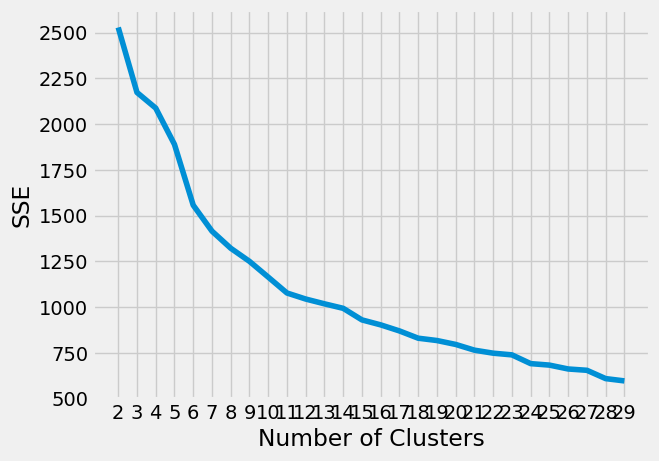

In [49]:
# Elbow curve to find optimal K 
kmeans_kwargs = {
    "init": "random",
    "n_init": 30,
    "max_iter": 300,
    "random_state": 42,
}

sse = []
silhouette_avg = {}
for k in range(2, 30):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    cluster_labels = kmeans.fit_predict(data)
    sse.append(kmeans.inertia_)
    silhouette_avg[k] = silhouette_score(data, cluster_labels)
    

print(silhouette_avg)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 30), sse)
plt.xticks(range(2, 30))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()


In [50]:
kmeans = KMeans(
    init="random",
    n_clusters=6,
    n_init=30,
    max_iter=300,
    random_state=42
)
clusters = kmeans.fit_predict(data) 
clusters

array([4, 4, 3, 4, 0, 0, 2, 3, 2, 1, 3, 3, 0, 0, 3, 4, 4, 4, 4, 4, 4, 2,
       4, 2, 0, 2, 2, 2, 3, 2, 4, 4, 4, 2, 4, 4, 4, 2, 4, 4, 4, 0, 0, 0,
       0, 3, 3, 0, 3, 5, 3, 0, 0, 0, 0, 0, 0, 5, 0, 0, 3, 0, 0, 0, 0, 0,
       5, 5, 5, 0, 0, 0, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 5, 3, 0, 0, 0,
       0, 0, 3, 0, 0, 0, 0, 5, 5, 0, 0, 3, 3], dtype=int32)

<Axes: >

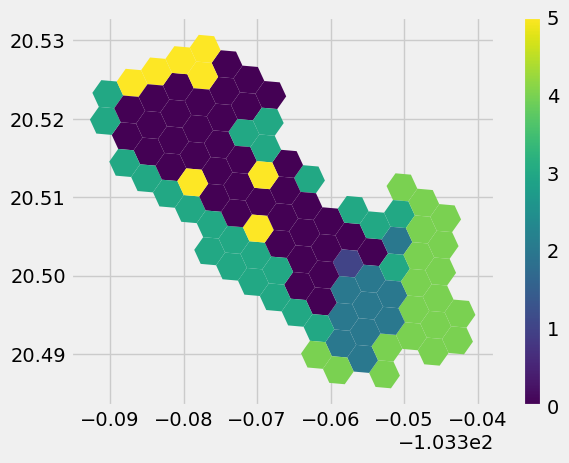

In [51]:
hex_mrg['cluster'] = clusters
hex_mrg.plot('cluster', legend=True)

In [52]:
hex_mrg.groupby('cluster').mean(numeric_only=True)

,nse_idx,graproes,dens_pob_ha,auto_viv,pct_0_17,pct_18_59,pct_60_mas,wgt_imn,denue_count,denue_jobs,...,pct_recreativo,pct_servicios,area_in_meters,number_intersections,max_time,max_entretenimiento,max_comercio,max_servicios comunitarios,max_escuelas,idx_sum
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.643043,9.484644,152.049721,0.368772,0.372647,0.582712,0.044641,0.947920,1190.519522,5430.191490,...,0.002550,0.025969,73.118027,35.076923,31.942939,28.586339,6.141201,26.931780,16.738953,12.270960
1,1.314364,8.411282,174.534222,0.199661,0.395091,0.568740,0.036170,0.923991,974.959184,4123.224490,...,0.000000,0.012348,57.430107,68.000000,43.681373,41.301920,4.967317,43.681373,13.530561,10.584465
2,1.261427,8.359566,129.052738,0.219273,0.400069,0.566066,0.033865,0.920889,713.807576,2931.865728,...,0.000593,0.018436,88.685683,34.700000,53.951581,53.274877,6.636594,53.821321,18.085480,9.789645
3,0.794717,8.862085,75.227703,0.289579,0.371306,0.552781,0.034246,0.901590,861.052146,3798.899125,...,0.001829,0.011936,71.643079,16.125000,40.461454,37.818349,11.518586,34.181116,19.485478,11.199219
4,1.295007,8.324169,59.273186,0.198150,0.398116,0.566036,0.035848,0.915059,362.753490,1454.822895,...,0.000000,0.006240,149.381329,17.000000,63.485777,62.065270,13.684638,63.192781,30.709338,8.366585
5,0.421990,9.840010,133.232943,0.420252,0.359102,0.589744,0.051154,0.953513,1324.500151,6233.611605,...,0.011539,0.070058,83.135809,26.875000,32.791925,21.980182,6.621060,28.665953,12.065004,12.743656


In [53]:
hex_mrg.groupby('cluster').count()

,hex_id_9,geometry,nse_idx,graproes,dens_pob_ha,auto_viv,pct_0_17,pct_18_59,pct_60_mas,wgt_imn,...,pct_recreativo,pct_servicios,area_in_meters,number_intersections,max_time,max_entretenimiento,max_comercio,max_servicios comunitarios,max_escuelas,idx_sum
cluster,,,,,,,,,,,,,,,,,,,,,
0,39,39,39,39,39,39,39,39,39,39,...,39,39,39,39,39,39,39,39,39,39
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
3,24,24,24,24,24,24,24,24,24,24,...,24,24,24,24,24,24,24,24,24,24
4,19,19,19,19,19,19,19,19,19,19,...,19,19,19,19,19,19,19,19,19,19
5,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8


In [54]:
hex_hm = hex_mrg.copy()
'''hex_hm = hex_hm.drop(columns=['denue_jobs_>_11','area_m2',
                               'denue_jobs','area_pob','denue_count',
                              'dens_pob_ha','wgt_imn','pct_jobs_>_11'])'''
hex_hm = hex_hm.groupby('cluster').mean(numeric_only=True)
# hex_hm = hex_hm.reset_index()

In [55]:
hex_hm.head(2)

,nse_idx,graproes,dens_pob_ha,auto_viv,pct_0_17,pct_18_59,pct_60_mas,wgt_imn,denue_count,denue_jobs,...,pct_recreativo,pct_servicios,area_in_meters,number_intersections,max_time,max_entretenimiento,max_comercio,max_servicios comunitarios,max_escuelas,idx_sum
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.643043,9.484644,152.049721,0.368772,0.372647,0.582712,0.044641,0.947920,1190.519522,5430.19149,...,0.00255,0.025969,73.118027,35.076923,31.942939,28.586339,6.141201,26.931780,16.738953,12.270960
1,1.314364,8.411282,174.534222,0.199661,0.395091,0.568740,0.036170,0.923991,974.959184,4123.22449,...,0.00000,0.012348,57.430107,68.000000,43.681373,41.301920,4.967317,43.681373,13.530561,10.584465


In [56]:
scaler = StandardScaler()
scaled_cluster = scaler.fit_transform(hex_hm)

In [57]:
scaled_df = pd.DataFrame(scaled_cluster, columns=hex_hm.columns)
scaled_df

,nse_idx,graproes,dens_pob_ha,auto_viv,pct_0_17,pct_18_59,pct_60_mas,wgt_imn,denue_count,denue_jobs,...,pct_recreativo,pct_servicios,area_in_meters,number_intersections,max_time,max_entretenimiento,max_comercio,max_servicios comunitarios,max_escuelas,idx_sum
0,-0.885115,1.024710,0.773283,1.001073,-0.641330,0.968999,0.831159,1.144224,0.908019,0.916357,...,-0.050021,0.084252,-0.478896,0.121704,-1.104526,-0.896586,-0.666653,-1.115956,-0.280614,0.978603
1,1.019067,-0.795232,1.325458,-0.963846,0.787384,-0.188303,-0.492277,-0.174692,0.223449,0.081617,...,-0.681174,-0.551673,-1.011185,2.017011,-0.062534,0.033963,-1.035728,0.145816,-0.811196,-0.163387
2,0.868911,-0.882920,0.208522,-0.735966,1.104276,-0.409759,-0.852278,-0.345666,-0.605909,-0.679287,...,-0.534362,-0.267450,0.049312,0.100005,0.849127,0.910166,-0.510899,0.909673,-0.057934,-0.701589
3,-0.454898,-0.030872,-1.113316,0.080915,-0.726691,-1.510185,-0.792729,-1.409338,-0.138294,-0.125525,...,-0.228524,-0.570904,-0.528941,-0.969315,-0.348358,-0.220971,1.024023,-0.569853,0.173588,0.252887
4,0.964161,-0.942936,-1.505127,-0.981400,0.979977,-0.412232,-0.542567,-0.666989,-1.720776,-1.622652,...,-0.681174,-0.836840,2.108704,-0.918943,1.695454,1.553463,1.705041,1.615639,2.029714,-1.665197
5,-1.512127,1.627251,0.311180,1.599223,-1.503616,1.551479,1.848692,1.452461,1.333511,1.429490,...,2.175255,2.142615,-0.138995,-0.350462,-1.029163,-1.380037,-0.515783,-0.985318,-1.053560,1.298684


In [58]:
scaled_stat_df = pd.DataFrame(scaled_df.min(axis=0)).reset_index().rename(columns={0:'min'})
tmp_df = pd.DataFrame(scaled_df.mean(axis=0)).reset_index().rename(columns={0:'mean'})
scaled_stat_df = scaled_stat_df.merge(tmp_df,on='index')
tmp_df = pd.DataFrame(scaled_df.max(axis=0)).reset_index().rename(columns={0:'max'})
scaled_stat_df = scaled_stat_df.merge(tmp_df,on='index')
scaled_stat_df.to_csv('../../../data/processed/viviendas_tlajo/scaled_stats.csv')
scaled_stat_df

,index,min,mean,max
0,nse_idx,-1.512127,-7.401487e-17,1.019067
1,graproes,-0.942936,9.992007e-16,1.627251
2,dens_pob_ha,-1.505127,1.202742e-16,1.325458
3,auto_viv,-0.981400,2.590520e-16,1.599223
4,pct_0_17,-1.503616,0.000000e+00,1.104276
5,pct_18_59,-1.510185,1.554312e-15,1.551479
6,pct_60_mas,-0.852278,-7.031412e-16,1.848692
7,wgt_imn,-1.409338,-4.107825e-15,1.452461
8,denue_count,-1.720776,-2.590520e-16,1.333511
9,denue_jobs,-1.622652,3.700743e-17,1.429490


In [59]:
hex_hm.mean(axis=0)

nse_idx                           0.955091
graproes                          8.880293
dens_pob_ha                     120.561752
auto_viv                          0.282615
pct_0_17                          0.382722
pct_18_59                         0.571013
pct_60_mas                        0.039321
wgt_imn                           0.927160
denue_count                     904.598678
denue_jobs                     3995.435889
denue_jobs_>_11                1195.166316
pct_jobs_>_11                     0.282508
pct_BANQUETA                      0.871632
pct_ALUMPUB                       0.538809
pct_RAMPAS                        0.801055
pct_ARBOLES                       0.511607
pct_CICLOVIA                      0.000144
ndvi_mean                         0.189915
temperature_mean                  2.454521
ndmi_diff                         0.144590
area_m2                       39530.942158
area_pob                         26.947150
dist_ep                           2.187690
pct_openspa

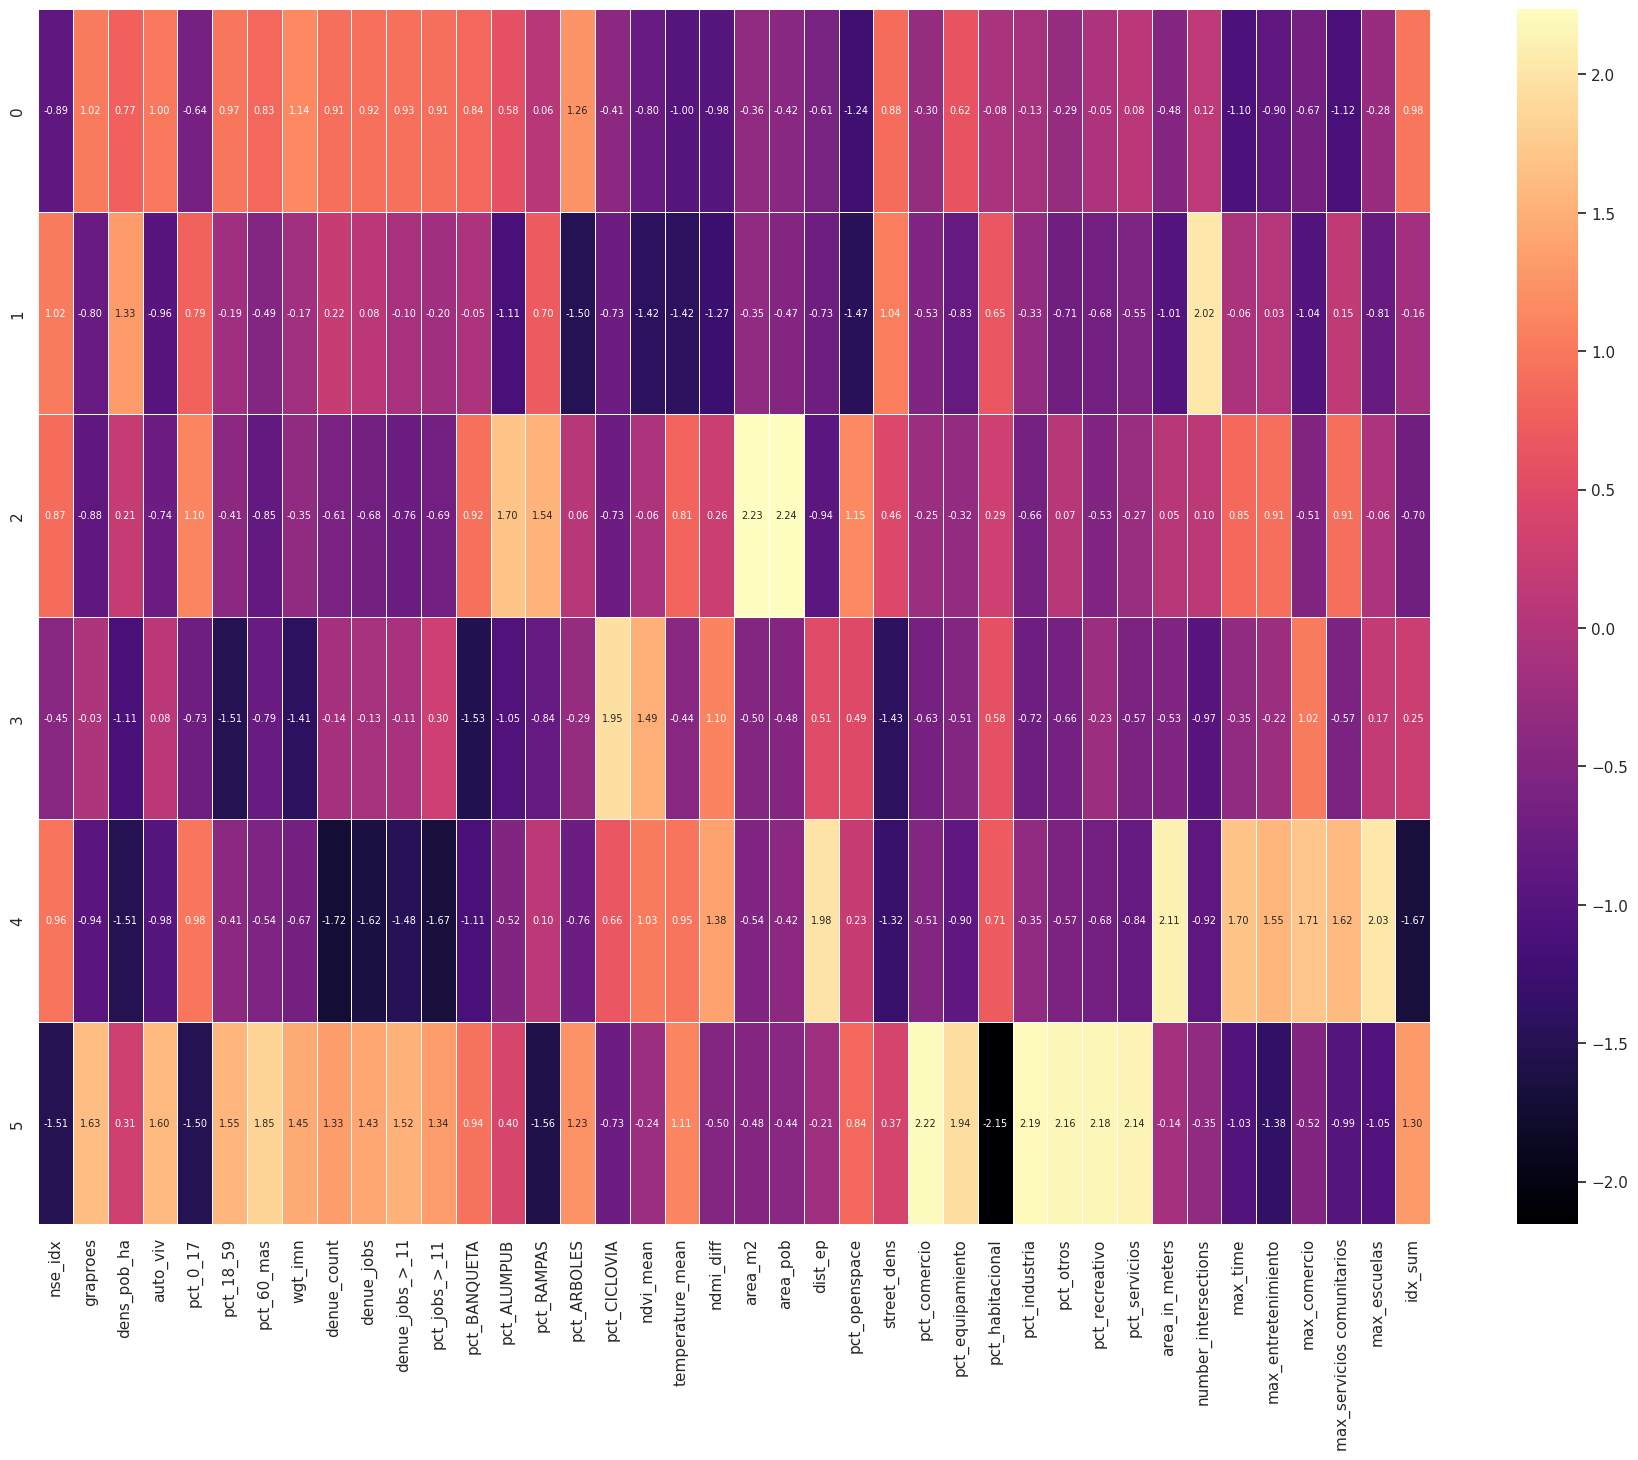

In [60]:
sns.set (rc = {'figure.figsize':(20,15)})

sns.heatmap(scaled_cluster, annot=scaled_cluster, 
            xticklabels=hex_hm.columns,
           fmt=".2f", linewidth=.5, cmap="magma",
           annot_kws={'size': 7})

plt.savefig('../../../output/figures/viviendas_tlajo/Clusters_Statistical_Std_Behaviour.png')

In [61]:
hex_mrg.to_file(f'{data_dir}hex_clusters.geojson')